## Regression Model (Part 2): Characterizing the Role of CREs for Gene Expression

### 0. Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.exceptions import ConvergenceWarning
import warnings

### 1. Importing and preparing dataframes for regression

   #### A. High variance ATAC-seq data

First, we will prepare our ATAC-seq data that was previously filtered for high variance. We will create three dataframes out of it:
- ***peaks_info***: contains the peak ID, the chromosome, and the position of the peak summit;

- ***peaks***: contains the accessibility data across all analyzed cell types; 

- ***peaks_transposed***: the transposed version of ***peaks*** (with the rows being the cell types).

In [2]:
peaks = pd.read_csv("ATAC_high_var.csv", index_col = False)
peaks.head()


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,preT.DN1.Th,preT.DN2a.Th,...,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,variance
0,ImmGenATAC1219.peak_69,chr1,4468579,0.00,7.11,1.0,NaN,"Rp1,Sox17",14.81,22.31,...,5.94,0.98,2.75,2.85,1.49,0.41,2.57,3.52,7.89,21.404348
1,ImmGenATAC1219.peak_77,chr1,4490652,0.08,16.20,1.0,NaN,"Rp1,Sox17",59.36,43.17,...,4.29,1.16,1.54,1.19,2.18,9.93,8.79,16.02,47.78,297.171420
2,ImmGenATAC1219.peak_83,chr1,4496479,0.40,23.81,1.0,NaN,"Rp1,Sox17",40.73,28.06,...,41.12,25.50,18.36,16.14,19.20,36.48,28.99,26.03,33.68,182.666600
3,ImmGenATAC1219.peak_84,chr1,4496738,0.14,11.15,1.0,NaN,"Rp1,Sox17",23.05,8.10,...,23.94,12.37,9.06,10.64,9.17,16.15,16.66,17.12,17.28,42.240147
4,ImmGenATAC1219.peak_93,chr1,4547574,0.14,41.55,1.0,NaN,Sox17,20.15,7.29,...,1.07,7.23,3.46,1.20,5.36,0.41,0.71,2.69,5.80,16.024600


In [3]:
print(peaks.columns.tolist())

['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


In [4]:
meta_cols = [
    "chrom",
    "Summit",         
    "mm10.60way.phastCons_scores", 
    "_-log10_bestPvalue",          
    "Included.in.systematic.analysis",
    "TSS",                         
    "genes.within.100Kb",
    "variance"           
]

peaks_info = peaks[["ImmGenATAC1219.peakID", "chrom", "Summit"]]
peaks_info.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"}, inplace=True)

peaks = peaks.drop(columns=meta_cols, errors="ignore")

C:\Users\boris\AppData\Local\Temp\ipykernel_19712\3725656176.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_info.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"}, inplace=True)


In [5]:
print("Kept columns:", peaks.columns.tolist())

print("ATAC shape:", peaks.shape)
peaks.head()
peaks_info.head()

Kept columns: ['ImmGenATAC1219.peakID', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM']
ATAC shape: (75857, 30)


,peak_ID,chrom,Summit
0,ImmGenATAC1219.peak_69,chr1,4468579
1,ImmGenATAC1219.peak_77,chr1,4490652
2,ImmGenATAC1219.peak_83,chr1,4496479
3,ImmGenATAC1219.peak_84,chr1,4496738
4,ImmGenATAC1219.peak_93,chr1,4547574


In [6]:
peaks_transposed = peaks.T
peaks_transposed = peaks_transposed.iloc[1:].set_axis(peaks_transposed.iloc[0], axis=1)

peaks_transposed.head()

ImmGenATAC1219.peakID,ImmGenATAC1219.peak_69,ImmGenATAC1219.peak_77,ImmGenATAC1219.peak_83,ImmGenATAC1219.peak_84,ImmGenATAC1219.peak_93,ImmGenATAC1219.peak_95,ImmGenATAC1219.peak_96,ImmGenATAC1219.peak_109,ImmGenATAC1219.peak_119,ImmGenATAC1219.peak_125,...,ImmGenATAC1219.peak_512506,ImmGenATAC1219.peak_512507,ImmGenATAC1219.peak_512523,ImmGenATAC1219.peak_512533,ImmGenATAC1219.peak_512559,ImmGenATAC1219.peak_512569,ImmGenATAC1219.peak_512573,ImmGenATAC1219.peak_512577,ImmGenATAC1219.peak_512584,ImmGenATAC1219.peak_512586
preT.DN1.Th,14.81,59.36,40.73,23.05,20.15,10.18,36.51,12.79,17.42,5.81,...,26.59,19.05,24.77,34.1,3.47,16.26,9.35,7.02,15.76,12.97
preT.DN2a.Th,22.31,43.17,28.06,8.1,7.29,17.64,43.92,8.76,21.59,6.49,...,15.01,10.46,30.09,37.56,3.22,15.23,13.75,11.95,19.36,16.9
preT.DN2b.Th,5.17,50.58,12.6,8.83,2.67,15.71,14.61,4.77,20.48,4.83,...,16.36,11.95,47.1,33.86,4.83,23.51,25.28,17.03,18.31,17.03
preT.DN3.Th,2.0,28.94,30.46,13.55,3.08,14.12,11.1,3.08,11.15,4.0,...,22.34,24.17,38.09,37.96,5.9,17.92,15.38,19.55,18.56,9.2
T.DN4.Th,3.54,4.62,14.85,8.17,2.89,8.03,6.11,2.76,8.41,2.29,...,13.57,16.93,34.49,34.34,9.35,33.73,24.35,27.28,19.63,17.73


#### B. RNA-seq gene expression data and annotation

In [7]:
genes = pd.read_csv("RNA-seq/filtered_RNA_abT_Tact_Stem.csv")

genes = (
    genes
    .rename(columns={"Unnamed: 0": "gene_symbol"})
    .set_index("gene_symbol")
)

print(genes.shape)
genes.head()

(17535, 29)


,preT.DN1.Th,preT.DN2a.Th,preT.DN2b.Th,preT.DN3.Th,T.DN4.Th,T.ISP.Th,T.DP.Th,T.4.Th,T.8.Th,T.4.Nve.Sp,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
gene_symbol,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,1.022363,1.389747,1.024819,1.024482,1.026430,1.026217,3.010920,1.024462,1.024819,2.726341,...,1.025833,1.024819,1.385805,1.025833,1.575395,1.024819,1.096732,1.096732,1.021750,1.021812
0610007P14Rik,162.641117,206.945221,209.187788,198.421365,215.056475,225.565360,73.904647,138.841383,139.863904,168.924363,...,206.241084,205.309922,165.690720,133.234920,127.894194,195.147548,206.053987,246.105317,192.424636,204.298358
0610009B22Rik,68.070719,82.468806,89.769337,57.661619,76.399214,84.671456,32.828651,27.207241,36.169759,32.753248,...,36.105700,34.348965,25.168975,33.305724,29.284365,33.322384,78.272059,78.837030,68.844751,76.418169
0610009L18Rik,15.450717,13.573968,14.427620,8.249482,1.683173,4.001953,5.595954,6.367369,6.505833,8.262234,...,8.645607,7.268431,3.840215,1.025833,6.283540,12.791348,8.577159,16.791386,15.511549,16.947354
0610009O20Rik,160.246297,125.475307,155.928005,120.692893,118.433597,149.630866,92.040668,76.781112,87.529814,86.523573,...,87.608325,56.128251,109.175415,91.992319,102.035627,108.414405,168.645852,157.926022,155.941641,186.261464


In [8]:
refFlat = pd.read_csv("refFlat", sep="\t", header=None)

refFlat.columns = [
    "gene", "transcript", "chrom", "strand", "txStart", "txEnd",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"
]

refFlat.head()

,gene,transcript,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5..."
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3..."
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3..."
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294..."
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,"


In [9]:
gene_annotation_df = refFlat.drop_duplicates(subset=["gene"])

gene_annotation_df["tss"] = gene_annotation_df.apply(
    lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"],
    axis=1
)

gene_annotation_df = gene_annotation_df[["gene", "chrom", "strand", "tss"]]

C:\Users\boris\AppData\Local\Temp\ipykernel_19712\1540322388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_annotation_df["tss"] = gene_annotation_df.apply(


In [10]:
gene_annotation_df.head()

,gene,chrom,strand,tss
0,Wdsub1,chr2,-,59882606
1,Rbm18,chr2,-,36136704
2,Prrc2b,chr2,+,32151147
3,Ildr2,chr1,+,166254138
4,Perm1,chr4,+,156215926


In [11]:
gene_annotation_df.head()

,gene,chrom,strand,tss
0,Wdsub1,chr2,-,59882606
1,Rbm18,chr2,-,36136704
2,Prrc2b,chr2,+,32151147
3,Ildr2,chr1,+,166254138
4,Perm1,chr4,+,156215926


#### C. Mapping peaks to genes

In [12]:
import pandas as pd

# !!! this actually means that we are taking 100 kb on each side of the TSS
window = 100_000

merged = pd.merge(peaks_info, gene_annotation_df, on='chrom')

merged['distance'] = abs(merged['Summit'] - merged['tss'])

nearby = merged[merged['distance'] <= window]

In [13]:
mapping_df = nearby[['gene', 'peak_ID']].drop_duplicates()

In [20]:
mapping_df.head()

,gene,peak_ID
57,Rp1,ImmGenATAC1219.peak_69
377,Sox17,ImmGenATAC1219.peak_69
1534,Rp1,ImmGenATAC1219.peak_77
1854,Sox17,ImmGenATAC1219.peak_77
3011,Rp1,ImmGenATAC1219.peak_83


In [26]:
genes_to_run = mapping_df['gene'].unique()[:1000]  # small test run

In [35]:
# Optional: Ignore convergence warnings for LASSO
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Prepare output
results = []

# Loop over all genes that exist in both 'genes' and 'mapping_df'
#for gene in genes_to_run: 
for gene in mapping_df['gene'].unique():
    if gene not in genes.index:
        continue
    
    # Get nearby peaks for this gene
    peaks_for_gene = mapping_df[mapping_df['gene'] == gene]['peak_ID'].tolist()
    valid_peaks = [p for p in peaks_for_gene if p in peaks_transposed.columns]
    
    # Skip if no valid peaks
    if not valid_peaks:
        continue
    
    # Subset predictors and response
    X = peaks_transposed[valid_peaks]
    y = genes.loc[gene]

    # Make sure the dimensions match
    if X.shape[0] != y.shape[0]:
        continue

    # Fit LASSO with cross-validation
    model = LassoCV(cv=5, random_state=0).fit(X, y)

    # Save non-zero coefficients
    for peak, coef in zip(X.columns, model.coef_):
        if coef != 0:
            results.append({
                'gene': gene,
                'peak_ID': peak,
                'coefficient': coef,
                'r2': model.score(X, y)
            })

# Convert to DataFrame
lasso_results = pd.DataFrame(results)

In [36]:
lasso_results.to_csv("regression_results.csv")

In [37]:
lasso_results.head()

,gene,peak_ID,coefficient,r2
0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561
1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538
2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538
3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538
4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855


### Visualization of regression results

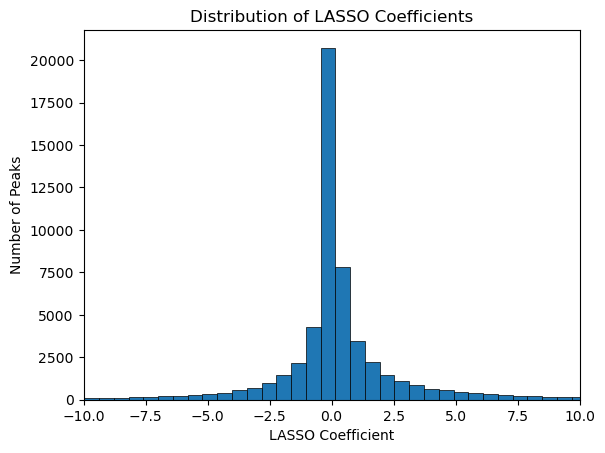

In [51]:
plt.hist(lasso_results["coefficient"], bins = 1000, edgecolor="black", linewidth=0.5)
plt.xlabel("LASSO Coefficient")
plt.xlim(-10, 10)
plt.ylabel("Number of Peaks")
plt.title("Distribution of LASSO Coefficients")
plt.show()

In [62]:
print(sum(lasso_results["coefficient"]==0))
print(lasso_results["coefficient"].min())
print(lasso_results["coefficient"].max())

0
-253.532701266754
341.96895867888975
